## Pre-Trained Model 활용 인터넷 사이트 캡차 숫자인식하기
ILSVRC(ImageNet Large-Scale Visual Recognition Challenge)란 컴퓨터 비전 분야의 '올림픽'으로 불리우는 대회이다. 아마도 딥러닝을 공부한 사람들이라면 한번 쯤 AlexNet이나 VGG, GoogleNet, ResNet에 대해 들어보았을 것이다. 이는 모두 ILSVRC 대회에서 매년 우승을 거머쥐었던 모델이다.
![ImageNet Classfication](images/MicrosoftImagNetResults.png)

출처 : https://www.bdti.com/InsideDSP/2017/06/29/Microsoft

Tranfer Learning과 ILSVRC가 무슨 연관이 있지? 라는 생각이 들텐데, 놀랍게도 우리는 ImageNet Classfication 대회에서 우승했던 모델과 그 가중치를 가져와 쓸 수 있는데, 이것이 바로 앞서 언급 했던 Pre-Trained Model이다.
![ResNet34](images/resnet34.png)

도대체 어떻게하면 이렇게 'Deep한' 모델을 가져다 쓸 수 있을까.

**model_ft = models.resnet18(pretrained=True)** 오늘의 핵심을 단 한 줄로 설명하면 바로 이 코드가 되겠다. torchvision 라이브러리에서는 ResNet 시리즈와 VGG 시리즈 등 ImageNet의 모든 대표작들을 잘 구현해 놓았다. 따라서 우리는 라이브러리에서 꺼내 쓰기만 하면 되는 것이다. 또한 Pre-Trained Weights의 경우, 모델을 불러올 때 파라미터로 pretrained=True 값만 입력해주면 자동으로 Weights 값을 불러올 수 있다.


**```model_ft = models.resnet18(pretrained=True)```**


여기서는 Pre-Trained Model을 캡차 이미지의 숫자인식 성능을 높이기 위해 Weights 값은 제외하고 ResNet에 사용된 알고리즘 모델만 이용 하겠으며,

**```model_ft = models.resnet18(pretrained=False)```**


이상과 같이 pretrained=False로 주고 활용 하게 됩니다.

신경망의 일반적인 학습 과정은 다음과 같습니다:

- 학습 가능한 매개변수(또는 가중치(weight))를 갖는 신경망을 정의합니다.

- 데이터셋(dataset) 입력을 반복합니다.

- 입력을 신경망에서 전파(process)합니다.

- 손실(loss; 출력이 정답으로부터 얼마나 떨어져있는지)을 계산합니다.

- 변화도(gradient)를 신경망의 매개변수들에 역으로 전파합니다.

- 신경망의 가중치를 갱신합니다. 일반적으로 다음과 같은 간단한 규칙을 사용합니다: 가중치(wiehgt) = 가중치(weight) - 학습율(learning rate) * 변화도(gradient)

In [1]:
import os
from torch.utils.data import DataLoader,Dataset
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
from torchvision import models
from pathlib import Path
# from fastai.vision import Path
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy


### 목적변수 처리를 위한 OneHot Vector 생성준비



In [2]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ALPHABET = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET = NUMBER + ALPHABET
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
MAX_CAPTCHA = 5

In [3]:
print("ALL_CHAR_SET : {}".format(ALL_CHAR_SET))
print("ALL_CHAR_SET_LEN : {}".format(ALL_CHAR_SET_LEN))

ALL_CHAR_SET : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALL_CHAR_SET_LEN : 36


### One - Hot Labels

이제 우리의 정답 y를 one hot vector로 바꿉시다.

one hot vector이란 모든 벡터의 원소들 중 하나만 1인 벡터를 의미합니다.

예를 들어, one hot vector로 0를 표현하면 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 이 될 수 있겠죠.(36개)


In [4]:
def encode(a):
    onehot = [0]*ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot

In [5]:
encode('0')
len(encode('0'))
print("encode('0') : {}".format(encode('0')))
print("len(encode('0')) : {}".format(len(encode('0'))))


encode('0') : [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len(encode('0')) : 36


### 종속변수 처리를 위한 데이터셋 불러오기
torch.utils.data.DataLoader를 이용해서 입력 데이터를 불러온다. DataLoader의 입력 파라미터로는 (경로, Transform 옵션)을 포함하는 ImageFolder함수와 배치사이즈, 그리고 셔플 옵션이 있다. DataLoader의 파라미터 중 하나인 num_workers는 스레드 갯수를 설정하는 것인데, 필자의 경우 4로 했을 때 오류가 발생해서 스레드 갯수를 0으로 설정했다.

​

* 처음 볼 땐 난해한 문법들이 많을 텐데, 파이썬 딕셔너리 자료형에 대한 개념을 안다면 무난하게 이해할 수 있다. 잘 이해가 안된다면 딕셔너리 자료형에 대한 내용을 한번 읽고 오도록 하자.

In [6]:
class Mydataset(Dataset):
    def __init__(self, path, is_train=True, transform=None):
        self.path = path
        if is_train: self.img = os.listdir(self.path)[:1000]
        else: self.img = os.listdir(self.path)[1001:]
        try: self.img.remove('3bnfnd.png')
        except: pass
        self.transform = transform
        
    def __getitem__(self, idx):
        img_path = self.img[idx]
        img = Image.open(self.path/img_path)
        img = img.convert('L')
        label = Path(self.path/img_path).name[:-4]
        label_oh = []
        for i in label:
            label_oh += encode(i)
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label
    
    def __len__(self):
        return len(self.img)

In [7]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

In [8]:
train_ds = Mydataset(Path('captcha-version-2-images/samples/samples'), transform=transform)
test_ds = Mydataset(Path('captcha-version-2-images/samples/samples'), False, transform)
train_dl = DataLoader(train_ds, batch_size=64, num_workers=0)
test_dl = DataLoader(train_ds, batch_size=1, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


일부 이미지 시각화하기 ^^^^^^^^^^^^^^^^^^^^^^^^^ 데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.

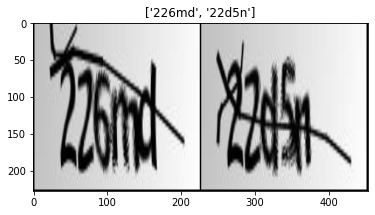

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

# 학습 데이터의 배치를 얻습니다.
# 한개의 배치(batch)만큼 이미지를 불러온다. 배치 사이즈를 64로 했으니 사진 64장이 로드된다.
dataiter = iter(train_dl)
inputs, label_oh, classes = dataiter.next()


# 배치로부터 격자 형태의 이미지를 만듭니다.
# 로드된 데이터에 make_grid 함수를 통해 그리드를 추가한다.
# 로드된 데이터 중에서 4개만 추출한다.
out = torchvision.utils.make_grid(inputs[:2])

# 이미지를 출력한다.
imshow(out, title=[x for x in classes[:2]])



In [10]:
print("inputs")
print(inputs[0])
print(inputs.size())

inputs
tensor([[[0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         [0.7529, 0.7529, 0.7529,  ..., 0.9843, 0.9843, 0.9843],
         ...,
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961],
         [0.7647, 0.7647, 0.7647,  ..., 0.9961, 0.9961, 0.9961]]])
torch.Size([64, 1, 224, 224])


In [11]:
print("label_oh")
print(label_oh[0])
print(label_oh.size())

label_oh
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
torch.Size([64, 180])


In [12]:
print("classes")
print(classes[0])
print(len(classes))

classes
226md
64


### ResNet18 모델기반 신경망 정의하기

이제 신경망을 정의해보겠습니다

Transfer Learning의 핵심! Pretrained model을 가져온다. 본 예제에서는 ResNet18 모델을 이용하였다. model_ft.fc.in_features는 ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수이다. Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 노드를 연결시켜 주는 것이 우리가 사용할 모델이 된다. 가장 핵심이지만 가장 심플하다고 할 수 있다.

​

*이 때, Fully connected layer 즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같아야한다.

본 예제는 캡차에 적용된 영숫자와 인식필요 캡차영숫자의 곱으로 이루어진 ALL_CHAR_SET_LEN*MAX_CAPTCHA이므로, 출력 노드 갯수는 ALL_CHAR_SET_LEN*MAX_CAPTCHA가 된다.

In [13]:
def get_model():
    """
    """
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN*MAX_CAPTCHA, bias=True)
    return model

# 모델 정의 
model = get_model().to(device)


### 손실함수정의

In [14]:
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.001)

### 모델 학습하기


In [15]:
since = time.time()
num_epochs = 50
for epoch in range(num_epochs):
    print(' ' * 50)
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = Variable(img).to(device)
        label_oh = Variable(label_oh.float()).to(device)
        pred = model(img)
        loss = loss_func(pred, label_oh)
        optm.zero_grad()
        loss.backward()
        optm.step()
        print('step:', step+1, 'loss:', loss.item())

time_elapsed = time.time() - since
print('=' * 50)
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


                                                  
Epoch 1/50
----------
step: 1 loss: 0.7121568918228149
step: 2 loss: 0.5127756595611572
step: 3 loss: 0.3482486307621002
step: 4 loss: 0.23610033094882965
step: 5 loss: 0.17493288218975067
step: 6 loss: 0.14907383918762207
step: 7 loss: 0.13778062164783478
step: 8 loss: 0.13166499137878418
step: 9 loss: 0.1261482536792755
step: 10 loss: 0.12962183356285095
step: 11 loss: 0.13475492596626282
step: 12 loss: 0.13365867733955383
step: 13 loss: 0.13443294167518616
step: 14 loss: 0.13050180673599243
step: 15 loss: 0.1316087543964386
step: 16 loss: 0.1311119645833969
                                                  
Epoch 2/50
----------
step: 1 loss: 0.12555938959121704
step: 2 loss: 0.12563444674015045
step: 3 loss: 0.12101024389266968
step: 4 loss: 0.118229940533638
step: 5 loss: 0.11634857952594757
step: 6 loss: 0.11332976073026657
step: 7 loss: 0.11118673533201218
step: 8 loss: 0.10977725684642792
step: 9 loss: 0.11207491159439087
step:

step: 2 loss: 0.06450172513723373
step: 3 loss: 0.0645587146282196
step: 4 loss: 0.06375741958618164
step: 5 loss: 0.06515467166900635
step: 6 loss: 0.06443691998720169
step: 7 loss: 0.06585682928562164
step: 8 loss: 0.06024914234876633
step: 9 loss: 0.06007245182991028
step: 10 loss: 0.06347645819187164
step: 11 loss: 0.06178172677755356
step: 12 loss: 0.0705738291144371
step: 13 loss: 0.06190270557999611
step: 14 loss: 0.05687319487333298
step: 15 loss: 0.0655984878540039
step: 16 loss: 0.05799633264541626
                                                  
Epoch 15/50
----------
step: 1 loss: 0.06120999902486801
step: 2 loss: 0.05815669894218445
step: 3 loss: 0.05801685154438019
step: 4 loss: 0.05863649398088455
step: 5 loss: 0.05998453125357628
step: 6 loss: 0.058788321912288666
step: 7 loss: 0.061337910592556
step: 8 loss: 0.05568515136837959
step: 9 loss: 0.05413080006837845
step: 10 loss: 0.056759729981422424
step: 11 loss: 0.05620155483484268
step: 12 loss: 0.06543218344449997
s

step: 2 loss: 0.015528585761785507
step: 3 loss: 0.015580723993480206
step: 4 loss: 0.015119190327823162
step: 5 loss: 0.01582183688879013
step: 6 loss: 0.0208608265966177
step: 7 loss: 0.018964966759085655
step: 8 loss: 0.014150703325867653
step: 9 loss: 0.011907007545232773
step: 10 loss: 0.013016428798437119
step: 11 loss: 0.017308900132775307
step: 12 loss: 0.023690270259976387
step: 13 loss: 0.02269231528043747
step: 14 loss: 0.01150880753993988
step: 15 loss: 0.012811852619051933
step: 16 loss: 0.019358200952410698
                                                  
Epoch 28/50
----------
step: 1 loss: 0.016332658007740974
step: 2 loss: 0.01438514981418848
step: 3 loss: 0.01368008553981781
step: 4 loss: 0.013671090826392174
step: 5 loss: 0.0126261031255126
step: 6 loss: 0.01842975988984108
step: 7 loss: 0.014688917435705662
step: 8 loss: 0.010795237496495247
step: 9 loss: 0.0130645502358675
step: 10 loss: 0.011200400069355965
step: 11 loss: 0.015426832251250744
step: 12 loss: 0.02

step: 1 loss: 0.004169050604104996
step: 2 loss: 0.004176510497927666
step: 3 loss: 0.004636870697140694
step: 4 loss: 0.003930611070245504
step: 5 loss: 0.0038205909077078104
step: 6 loss: 0.005285825114697218
step: 7 loss: 0.004448367282748222
step: 8 loss: 0.0034399135038256645
step: 9 loss: 0.0032521551474928856
step: 10 loss: 0.0029954733327031136
step: 11 loss: 0.004346301779150963
step: 12 loss: 0.006878091488033533
step: 13 loss: 0.006937071681022644
step: 14 loss: 0.002772189676761627
step: 15 loss: 0.003456958569586277
step: 16 loss: 0.0051130508072674274
                                                  
Epoch 41/50
----------
step: 1 loss: 0.004180327523499727
step: 2 loss: 0.004115467891097069
step: 3 loss: 0.0030369791202247143
step: 4 loss: 0.003394809551537037
step: 5 loss: 0.0032146545127034187
step: 6 loss: 0.004585231654345989
step: 7 loss: 0.0041433051228523254
step: 8 loss: 0.0029532478656619787
step: 9 loss: 0.0025367410853505135
step: 10 loss: 0.00254839099943637

### 모델 예측값 시각화하기
일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    test_correct = 0
    test_total = len(test_dl.dataset)

    with torch.no_grad():
        for i, (inputs, label_oh, label) in enumerate(test_dl):
            
            view_image = torchvision.utils.make_grid(inputs)
            inputs = Variable(inputs).to(device)
#             labels = labels.to(device)

            outputs = model(inputs)
    
            c0 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
            c1 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
            c2 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
            c3 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
            c4 = ALL_CHAR_SET[np.argmax(outputs.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
            preds_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)

            correct = ""
            if label[0] == preds_label:
                test_correct += 1
                correct = "True"
            else:
                correct = "False"
                
            
            print("Lable : {} Prediction Lable : {} 맟춤여부 : {}".format(label[0], preds_label, correct))

            # 맞추지 못한 이미지를 출력한다.
            if (correct == "False") and (num_images > i):
                imshow(view_image, title='{} predicted: {}  {}'.format(i+1, preds_label, correct))

        model.train(mode=was_training)
        
    print(f'Test Accuracy: {(test_correct/test_total):.5f} ' +  f'({test_correct}/{test_total})')


### 모델 학습결과 테스트 데이터로 테스트

In [17]:
visualize_model(model)

Lable : 226md Prediction Lable : 226md 맟춤여부 : True
Lable : 22d5n Prediction Lable : 22d5n 맟춤여부 : True
Lable : 2356g Prediction Lable : 2356g 맟춤여부 : True
Lable : 23mdg Prediction Lable : 23mdg 맟춤여부 : True
Lable : 23n88 Prediction Lable : 23n88 맟춤여부 : True
Lable : 243mm Prediction Lable : 243mm 맟춤여부 : True
Lable : 244e2 Prediction Lable : 244e2 맟춤여부 : True
Lable : 245y5 Prediction Lable : 245y5 맟춤여부 : True
Lable : 24f6w Prediction Lable : 24f6w 맟춤여부 : True
Lable : 24pew Prediction Lable : 24pew 맟춤여부 : True
Lable : 25257 Prediction Lable : 25257 맟춤여부 : True
Lable : 253dc Prediction Lable : 253dc 맟춤여부 : True
Lable : 25egp Prediction Lable : 25egp 맟춤여부 : True
Lable : 25m6p Prediction Lable : 25m6p 맟춤여부 : True
Lable : 25p2m Prediction Lable : 25p2m 맟춤여부 : True
Lable : 25w53 Prediction Lable : 25w53 맟춤여부 : True
Lable : 264m5 Prediction Lable : 264m5 맟춤여부 : True
Lable : 268g2 Prediction Lable : 268g2 맟춤여부 : True
Lable : 28348 Prediction Lable : 28348 맟춤여부 : True
Lable : 28x47 Prediction Lable 

Lable : 5mgn4 Prediction Lable : 5mgn4 맟춤여부 : True
Lable : 5mnpd Prediction Lable : 5mnpd 맟춤여부 : True
Lable : 5n245 Prediction Lable : 5n245 맟춤여부 : True
Lable : 5n3w4 Prediction Lable : 5n3w4 맟춤여부 : True
Lable : 5n728 Prediction Lable : 5n728 맟춤여부 : True
Lable : 5n732 Prediction Lable : 5n732 맟춤여부 : True
Lable : 5ng6e Prediction Lable : 5ng6e 맟춤여부 : True
Lable : 5nggg Prediction Lable : 5nggg 맟춤여부 : True
Lable : 5nm6d Prediction Lable : 5nm6d 맟춤여부 : True
Lable : 5nnff Prediction Lable : 5nnff 맟춤여부 : True
Lable : 5np4m Prediction Lable : 5np4m 맟춤여부 : True
Lable : 5npdn Prediction Lable : 5npdn 맟춤여부 : True
Lable : 5nxnn Prediction Lable : 5nxnn 맟춤여부 : True
Lable : 5p3mm Prediction Lable : 5p3mm 맟춤여부 : True
Lable : 5p8fm Prediction Lable : 5p8fm 맟춤여부 : True
Lable : 5pm6b Prediction Lable : 5pm6b 맟춤여부 : True
Lable : 5wddw Prediction Lable : 5wddw 맟춤여부 : True
Lable : 5x5nx Prediction Lable : 5x5nx 맟춤여부 : True
Lable : 5x7x5 Prediction Lable : 5x7x5 맟춤여부 : True
Lable : 5xd2e Prediction Lable 

Lable : 8xef7 Prediction Lable : 8xef7 맟춤여부 : True
Lable : 8y63f Prediction Lable : 8y63f 맟춤여부 : True
Lable : 8y6b3 Prediction Lable : 8y6b3 맟춤여부 : True
Lable : 8ypdn Prediction Lable : 8ypdn 맟춤여부 : True
Lable : b26nd Prediction Lable : b26nd 맟춤여부 : True
Lable : b28g8 Prediction Lable : b28g8 맟춤여부 : True
Lable : b2g8e Prediction Lable : b2g8e 맟춤여부 : True
Lable : b2nen Prediction Lable : b2nen 맟춤여부 : True
Lable : b35f6 Prediction Lable : b35f6 맟춤여부 : True
Lable : b3xpn Prediction Lable : b3xpn 맟춤여부 : True
Lable : b43nw Prediction Lable : b43nw 맟춤여부 : True
Lable : b4d7c Prediction Lable : b4d7c 맟춤여부 : True
Lable : b4ncn Prediction Lable : b4ncn 맟춤여부 : True
Lable : b4ndb Prediction Lable : b4ndb 맟춤여부 : True
Lable : b4y5x Prediction Lable : b4y5x 맟춤여부 : True
Lable : b55d6 Prediction Lable : b55d6 맟춤여부 : True
Lable : b5dn4 Prediction Lable : b5dn4 맟춤여부 : True
Lable : b5fm7 Prediction Lable : b5fm7 맟춤여부 : True
Lable : b5nmm Prediction Lable : b5nmm 맟춤여부 : True
Lable : b5pnn Prediction Lable 

Lable : e667x Prediction Lable : e667x 맟춤여부 : True
Lable : e6b7y Prediction Lable : e6b7y 맟춤여부 : True
Lable : e6m6p Prediction Lable : e6m6p 맟춤여부 : True
Lable : e72cd Prediction Lable : e72cd 맟춤여부 : True
Lable : e76n4 Prediction Lable : e76n4 맟춤여부 : True
Lable : e7nx4 Prediction Lable : e7nx4 맟춤여부 : True
Lable : e7x45 Prediction Lable : e7x45 맟춤여부 : True
Lable : e84n2 Prediction Lable : e84n2 맟춤여부 : True
Lable : e8dxn Prediction Lable : e8dxn 맟춤여부 : True
Lable : e8e5e Prediction Lable : e8e5e 맟춤여부 : True
Lable : ebcbx Prediction Lable : ebcbx 맟춤여부 : True
Lable : ec6pm Prediction Lable : ec6pm 맟춤여부 : True
Lable : ecd4w Prediction Lable : ecd4w 맟춤여부 : True
Lable : edg3p Prediction Lable : edg3p 맟춤여부 : True
Lable : edwny Prediction Lable : edwny 맟춤여부 : True
Lable : ee8fg Prediction Lable : ee8fg 맟춤여부 : True
Lable : een23 Prediction Lable : een23 맟춤여부 : True
Lable : ef4mn Prediction Lable : ef4mn 맟춤여부 : True
Lable : ef4np Prediction Lable : ef4np 맟춤여부 : True
Lable : efb3f Prediction Lable 

Lable : mc8w2 Prediction Lable : mc8w2 맟춤여부 : True
Lable : mcc2x Prediction Lable : mcc2x 맟춤여부 : True
Lable : mcg43 Prediction Lable : mcg43 맟춤여부 : True
Lable : mcyfx Prediction Lable : mcyfx 맟춤여부 : True
Lable : md344 Prediction Lable : md344 맟춤여부 : True
Lable : mddgb Prediction Lable : mddgb 맟춤여부 : True
Lable : mdxpn Prediction Lable : mdxpn 맟춤여부 : True
Lable : mdyp7 Prediction Lable : mdyp7 맟춤여부 : True
Lable : men4f Prediction Lable : men4f 맟춤여부 : True
Lable : mfb3x Prediction Lable : mfb3x 맟춤여부 : True
Lable : mfc35 Prediction Lable : mfc35 맟춤여부 : True
Lable : mg5nn Prediction Lable : mg5nn 맟춤여부 : True
Lable : mgdwb Prediction Lable : mgdwb 맟춤여부 : True
Lable : mggce Prediction Lable : mggce 맟춤여부 : True
Lable : mgw3n Prediction Lable : mgw3n 맟춤여부 : True
Lable : mm3nn Prediction Lable : mm3nn 맟춤여부 : True
Lable : mmc5n Prediction Lable : mmc5n 맟춤여부 : True
Lable : mmfm6 Prediction Lable : mmfm6 맟춤여부 : True
Lable : mmg2m Prediction Lable : mmg2m 맟춤여부 : True
Lable : mmg38 Prediction Lable 

Lable : pwmbn Prediction Lable : pwmbn 맟춤여부 : True
Lable : pwn5e Prediction Lable : pwn5e 맟춤여부 : True
Lable : px2xp Prediction Lable : px2xp 맟춤여부 : True
Lable : px8n8 Prediction Lable : px8n8 맟춤여부 : True
Lable : pxdwp Prediction Lable : pxdwp 맟춤여부 : True
Lable : pxne8 Prediction Lable : pxne8 맟춤여부 : True
Lable : pybee Prediction Lable : pybee 맟춤여부 : True
Lable : pyefb Prediction Lable : pyefb 맟춤여부 : True
Lable : pyf65 Prediction Lable : pyf65 맟춤여부 : True
Lable : pym7p Prediction Lable : pym7p 맟춤여부 : True
Lable : w2e87 Prediction Lable : w2e87 맟춤여부 : True
Lable : w2n7e Prediction Lable : w2n7e 맟춤여부 : True
Lable : w2yp7 Prediction Lable : w2yp7 맟춤여부 : True
Lable : w46ep Prediction Lable : w46ep 맟춤여부 : True
Lable : w48cw Prediction Lable : w48cw 맟춤여부 : True
Lable : w4cdc Prediction Lable : w4cdc 맟춤여부 : True
Lable : w4cnn Prediction Lable : w4cnn 맟춤여부 : True
Lable : w4nfx Prediction Lable : w4nfx 맟춤여부 : True
Lable : w4x2m Prediction Lable : w4x2m 맟춤여부 : True
Lable : w52fn Prediction Lable 

<Figure size 432x288 with 0 Axes>

### 학습한 모델 저장
지금까지 인공신경망을 구현하고 학습시켜 보았습니다. 이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [18]:
torch.save(model.state_dict(), 'model/CaptchaBreaking_Model.pt')
print("save last model")


save last model


save() 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 CaptchaBreaking_Model.pt 라는 파일이 생성됩니다.

아래 코드처럼 CaptchaBreaking_Model.pt를 다시 load하는 것도 가능합니다.

In [19]:
new_model = get_model().to(device)
new_model = new_model.eval()
new_model.load_state_dict(torch.load('model/CaptchaBreaking_Model.pt'))
print("load saved_model.")


load saved_model.


업로드한 모델로 다시한번 테스트

In [20]:
visualize_model(new_model)

Lable : 226md Prediction Lable : 226md 맟춤여부 : True
Lable : 22d5n Prediction Lable : 22d5n 맟춤여부 : True
Lable : 2356g Prediction Lable : 2356g 맟춤여부 : True
Lable : 23mdg Prediction Lable : 23mdg 맟춤여부 : True
Lable : 23n88 Prediction Lable : 23n88 맟춤여부 : True
Lable : 243mm Prediction Lable : 243mm 맟춤여부 : True
Lable : 244e2 Prediction Lable : 244e2 맟춤여부 : True
Lable : 245y5 Prediction Lable : 245y5 맟춤여부 : True
Lable : 24f6w Prediction Lable : 24f6w 맟춤여부 : True
Lable : 24pew Prediction Lable : 24pew 맟춤여부 : True
Lable : 25257 Prediction Lable : 25257 맟춤여부 : True
Lable : 253dc Prediction Lable : 253dc 맟춤여부 : True
Lable : 25egp Prediction Lable : 25egp 맟춤여부 : True
Lable : 25m6p Prediction Lable : 25m6p 맟춤여부 : True
Lable : 25p2m Prediction Lable : 25p2m 맟춤여부 : True
Lable : 25w53 Prediction Lable : 25w53 맟춤여부 : True
Lable : 264m5 Prediction Lable : 264m5 맟춤여부 : True
Lable : 268g2 Prediction Lable : 268g2 맟춤여부 : True
Lable : 28348 Prediction Lable : 28348 맟춤여부 : True
Lable : 28x47 Prediction Lable 

Lable : 5n245 Prediction Lable : 5n245 맟춤여부 : True
Lable : 5n3w4 Prediction Lable : 5n3w4 맟춤여부 : True
Lable : 5n728 Prediction Lable : 5n728 맟춤여부 : True
Lable : 5n732 Prediction Lable : 5n732 맟춤여부 : True
Lable : 5ng6e Prediction Lable : 5ng6e 맟춤여부 : True
Lable : 5nggg Prediction Lable : 5nggg 맟춤여부 : True
Lable : 5nm6d Prediction Lable : 5nm6d 맟춤여부 : True
Lable : 5nnff Prediction Lable : 5nnff 맟춤여부 : True
Lable : 5np4m Prediction Lable : 5np4m 맟춤여부 : True
Lable : 5npdn Prediction Lable : 5npdn 맟춤여부 : True
Lable : 5nxnn Prediction Lable : 5nxnn 맟춤여부 : True
Lable : 5p3mm Prediction Lable : 5p3mm 맟춤여부 : True
Lable : 5p8fm Prediction Lable : 5p8fm 맟춤여부 : True
Lable : 5pm6b Prediction Lable : 5pm6b 맟춤여부 : True
Lable : 5wddw Prediction Lable : 5wddw 맟춤여부 : True
Lable : 5x5nx Prediction Lable : 5x5nx 맟춤여부 : True
Lable : 5x7x5 Prediction Lable : 5x7x5 맟춤여부 : True
Lable : 5xd2e Prediction Lable : 5xd2e 맟춤여부 : True
Lable : 5xwcg Prediction Lable : 5xwcg 맟춤여부 : True
Lable : 5ywwf Prediction Lable 

Lable : 8npd5 Prediction Lable : 8npd5 맟춤여부 : True
Lable : 8npe3 Prediction Lable : 8npe3 맟춤여부 : True
Lable : 8pfxx Prediction Lable : 8pfxx 맟춤여부 : True
Lable : 8w754 Prediction Lable : 8w754 맟춤여부 : True
Lable : 8w875 Prediction Lable : 8w875 맟춤여부 : True
Lable : 8wy7d Prediction Lable : 8wy7d 맟춤여부 : True
Lable : 8xef7 Prediction Lable : 8xef7 맟춤여부 : True
Lable : 8y63f Prediction Lable : 8y63f 맟춤여부 : True
Lable : 8y6b3 Prediction Lable : 8y6b3 맟춤여부 : True
Lable : 8ypdn Prediction Lable : 8ypdn 맟춤여부 : True
Lable : b26nd Prediction Lable : b26nd 맟춤여부 : True
Lable : b28g8 Prediction Lable : b28g8 맟춤여부 : True
Lable : b2g8e Prediction Lable : b2g8e 맟춤여부 : True
Lable : b2nen Prediction Lable : b2nen 맟춤여부 : True
Lable : b35f6 Prediction Lable : b35f6 맟춤여부 : True
Lable : b3xpn Prediction Lable : b3xpn 맟춤여부 : True
Lable : b43nw Prediction Lable : b43nw 맟춤여부 : True
Lable : b4d7c Prediction Lable : b4d7c 맟춤여부 : True
Lable : b4ncn Prediction Lable : b4ncn 맟춤여부 : True
Lable : b4ndb Prediction Lable 

Lable : dxwcw Prediction Lable : dxwcw 맟춤여부 : True
Lable : dy3cx Prediction Lable : dy3cx 맟춤여부 : True
Lable : dyp7n Prediction Lable : dyp7n 맟춤여부 : True
Lable : dyxnc Prediction Lable : dyxnc 맟춤여부 : True
Lable : e25xg Prediction Lable : e25xg 맟춤여부 : True
Lable : e2d66 Prediction Lable : e2d66 맟춤여부 : True
Lable : e2mg2 Prediction Lable : e2mg2 맟춤여부 : True
Lable : e3cfe Prediction Lable : e3cfe 맟춤여부 : True
Lable : e3ndn Prediction Lable : e3ndn 맟춤여부 : True
Lable : e43ym Prediction Lable : e43ym 맟춤여부 : True
Lable : e46pd Prediction Lable : e46pd 맟춤여부 : True
Lable : e46yw Prediction Lable : e46yw 맟춤여부 : True
Lable : e4gd7 Prediction Lable : e4gd7 맟춤여부 : True
Lable : e5n66 Prediction Lable : e5n66 맟춤여부 : True
Lable : e667x Prediction Lable : e667x 맟춤여부 : True
Lable : e6b7y Prediction Lable : e6b7y 맟춤여부 : True
Lable : e6m6p Prediction Lable : e6m6p 맟춤여부 : True
Lable : e72cd Prediction Lable : e72cd 맟춤여부 : True
Lable : e76n4 Prediction Lable : e76n4 맟춤여부 : True
Lable : e7nx4 Prediction Lable 

Lable : m6n4x Prediction Lable : m6n4x 맟춤여부 : True
Lable : m74dm Prediction Lable : m74dm 맟춤여부 : True
Lable : m75bf Prediction Lable : m75bf 맟춤여부 : True
Lable : m8gmx Prediction Lable : m8gmx 맟춤여부 : True
Lable : m8m4x Prediction Lable : m8m4x 맟춤여부 : True
Lable : mb4en Prediction Lable : mb4en 맟춤여부 : True
Lable : mbf58 Prediction Lable : mbf58 맟춤여부 : True
Lable : mbp2y Prediction Lable : mbp2y 맟춤여부 : True
Lable : mc35n Prediction Lable : mc35n 맟춤여부 : True
Lable : mc8w2 Prediction Lable : mc8w2 맟춤여부 : True
Lable : mcc2x Prediction Lable : mcc2x 맟춤여부 : True
Lable : mcg43 Prediction Lable : mcg43 맟춤여부 : True
Lable : mcyfx Prediction Lable : mcyfx 맟춤여부 : True
Lable : md344 Prediction Lable : md344 맟춤여부 : True
Lable : mddgb Prediction Lable : mddgb 맟춤여부 : True
Lable : mdxpn Prediction Lable : mdxpn 맟춤여부 : True
Lable : mdyp7 Prediction Lable : mdyp7 맟춤여부 : True
Lable : men4f Prediction Lable : men4f 맟춤여부 : True
Lable : mfb3x Prediction Lable : mfb3x 맟춤여부 : True
Lable : mfc35 Prediction Lable 

Lable : ppx77 Prediction Lable : ppx77 맟춤여부 : True
Lable : pw5nc Prediction Lable : pw5nc 맟춤여부 : True
Lable : pwebm Prediction Lable : pwebm 맟춤여부 : True
Lable : pwmbn Prediction Lable : pwmbn 맟춤여부 : True
Lable : pwn5e Prediction Lable : pwn5e 맟춤여부 : True
Lable : px2xp Prediction Lable : px2xp 맟춤여부 : True
Lable : px8n8 Prediction Lable : px8n8 맟춤여부 : True
Lable : pxdwp Prediction Lable : pxdwp 맟춤여부 : True
Lable : pxne8 Prediction Lable : pxne8 맟춤여부 : True
Lable : pybee Prediction Lable : pybee 맟춤여부 : True
Lable : pyefb Prediction Lable : pyefb 맟춤여부 : True
Lable : pyf65 Prediction Lable : pyf65 맟춤여부 : True
Lable : pym7p Prediction Lable : pym7p 맟춤여부 : True
Lable : w2e87 Prediction Lable : w2e87 맟춤여부 : True
Lable : w2n7e Prediction Lable : w2n7e 맟춤여부 : True
Lable : w2yp7 Prediction Lable : w2yp7 맟춤여부 : True
Lable : w46ep Prediction Lable : w46ep 맟춤여부 : True
Lable : w48cw Prediction Lable : w48cw 맟춤여부 : True
Lable : w4cdc Prediction Lable : w4cdc 맟춤여부 : True
Lable : w4cnn Prediction Lable 

<Figure size 432x288 with 0 Axes>

### 학습모델이용 캡차 이미지 숫자인식
이미지 파일을 주고 이미지 파일 내에 있는 글자를 출력한다

type: <class 'PIL.PngImagePlugin.PngImageFile'>
size of image: (160, 60)


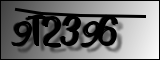

In [1]:
# 코드 3-1

import matplotlib.pyplot as plt
from PIL import Image

img = Image.open('captcha-version-2-images/samples/samples/677g3.png')
# img = Image.open('captcha-version-2-images/captcha01.png')
# PIL 객체 확인
print("type: {}".format(type(img)))
# 이미지 흑백으로 변경, 크기변화: 150x150x3 > 150x150x1
img = img.convert("L") 
# 이미지 크기 조회
print("size of image: {}".format(img.size))
img

In [2]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    # Load Image
    img = img.convert('L')
    # Resize Image [1, 224, 224]
    img = transform(img)
    
    # Turn image into numpy array
    img = np.array(img)
    
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
#     # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [3]:
input = process_image('captcha-version-2-images/samples/samples/677g3.png')
print(input.size())
plt.imshow(input.squeeze().detach().numpy(), cmap="gray")
plt.axis("off")
plt.show()
# image = input[:,0][:,None].type(torch.FloatTensor).to(device) # select only 1 channel (all channel equal)
# print(image.size())


NameError: name 'transform' is not defined

In [24]:
def get_predict(model, path):

    model.eval()
    predict_label = ""
    input = process_image(path)
    print(input.size())
    
    img = Variable(input).to(device)

    output = model(img)

    c0 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN*2])]
    c2 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*2:ALL_CHAR_SET_LEN*3])]
    c3 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*3:ALL_CHAR_SET_LEN*4])]
    c4 = ALL_CHAR_SET[np.argmax(output.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*4:ALL_CHAR_SET_LEN*5])]
    predict_label = '%s%s%s%s%s' % (c0, c1, c2, c3, c4)

   
    return predict_label
    


In [25]:
get_predict(new_model, 'captcha-version-2-images/samples/samples/677g3.png')

torch.Size([1, 1, 224, 224])


'677g3'